In a nutshell, the word2vec algorithm takes a corpus of text as input and generates a vector of several hundred dimensions for each word in the corpus. In doing this, it doesn't rely on the counts of the occurrences of the words. Instead, it follows a much more complicated procedure that considers the surrounding words of each word in the sentences.

Before moving further, note that you're still in the feature-engineering step as shown below:

![Feature Engineering](assets/feature_engineering.png)



# What is word2vec?

The most common feature-generation approach for NLP tasks is word2vec. What word2vec does is that it trains a shallow neural network model in an unsupervised manner for converting words to vectors. At the highest level of abstraction, word2vec assigns a vector of random values to each word. For a word *W*, it looks at the words that are near *W* in the sentence. It then shifts the values in the word vectors, such that the vectors for words near *W* are closer to the *W* vector, and vectors for words not near *W* are farther away from the *W* vector. With a large enough corpus, this will eventually result in words that often appear together having vectors that are near one another, and words that rarely or never appear together having vectors that are far away from each other.

This may sound quite similar to the latent semantic analysis approach that you learned about in the previous checkpoint. The conceptual difference is that LSA creates vector representations of sentences based on the words in them, while word2vec creates representations of individual words, based on the words around them.

## What is it good for?

Word2vec is strong at capturing the meanings of the words, so it's also good at detecting words that have similar meanings. The challenge with human communication is that there are many different ways to communicate the same concept. It's easy for humans to know that `the silverware` and `the utensils` can refer to the same thing. But computers can't do that unless you teach them, and this can be a real choke point for human-computer interactions. If you've ever played a text adventure game like *Colossal Cave Adventure* or *Zork*, you may have encountered the following scenario:

    GAME: You are on a forest path north of the field. A cave leads into a granite butte to the north.
    A thick hedge blocks the way to the west.
    A hefty stick lies on the ground.

    YOU: pick up stick  

    GAME: You don't know how to do that.  

    YOU: lift stick  

    GAME: You don't know how to do that.  

    YOU: take stick  

    GAME: You don't know how to do that.  

    YOU: grab stick  

    GAME: You grab the stick from the ground and put it in your bag.  

And your brain explodes from frustration. A text adventure game that incorporates a properly trained word2vec model would have vectors for `pick up`, `lift`, and `take` that are close to the vector for `grab`. Therefore, it could accept those other verbs as synonyms so that you could move ahead faster. In more practical applications, word2vec and other similar algorithms are what help a search engine return the best results for your query, not just the results that contain the exact words that you used. In fact, a search is a better example. Not only does the search engine need to understand your request, it also needs to match it to web pages that were also written by humans and therefore also use idiosyncratic language.

Next, look very briefly at the word2vec algorithm and examine how it comes up with vector representations of words that capture semantics.

## Generating vectors: Multiple algorithms

In considering the relationship between a word and its surrounding words, word2vec has two options that are the inverse of one another:

 * **Continuous bag of words (CBOW):** The identity of a word is predicted using the words near it in a sentence.
 * **Skip-gram:** The identities of words are predicted from the word that they surround. Skip-gram seems to work better for larger corpora.

Now, consider the following sentence:
    
    "Terry Gilliam is a better comedian than a director" 

Focus on the word `comedian` here. CBOW will try to predict `comedian` using `is`, `a`, `better`, `than`, `a`, and `director`. Skip-gram will try to predict `is`, `a`, `better`, `than`, `a`, and `director` using the word `comedian`. In practice, for CBOW, the vector for `comedian` will be pulled closer to the other words. But for skip-gram, the vectors for the other words will be pulled closer to `comedian`.  

In addition to moving the vectors for nearby words closer together, each time a word is processed, some vectors are moved farther away. Word2vec has two approaches to pushing vectors apart:
 
 * **Negative sampling:** Like it sounds, each time that a word is pulled toward some neighbors, the vectors for a randomly chosen small set of other words are pushed away.
 * **Hierarchical softmax:** Every neighboring word is pulled closer or farther from a subset of words chosen based on a tree of probabilities.

## What is similarity? Strengths and weaknesses of word2vec

Keep in mind that word2vec operates on the assumption that frequent proximity indicates similarity, but words can be similar in various ways. They may be conceptually similar (`royal`, `king`, and `throne`), but they may also be functionally similar (`tremendous` and `negligible` are both common modifiers of `size`). Here is a more [detailed exploration, with examples](https://quomodocumque.wordpress.com/2016/01/15/messing-around-with-word2vec/), of what similarity means in word2vec.

One cool thing about word2vec is that it can identify similarities between words that never occur near one another in the corpus. For example, consider these sentences:

    "The dog played with an elastic ball."
    "Babies prefer the ball that is bouncy."
    "I wanted to find a ball that's elastic."
    "Tracy threw a bouncy ball."

`Elastic` and `bouncy` are similar in meaning in the text but don't appear in the same sentence. However, both appear near `ball`. In the process of nudging the vectors around so that `elastic` and `bouncy` are both near the vector for `ball`, the words also become nearer to one another and their similarity can be detected.

For a while, after it was introduced, [no one was really sure why word2vec worked as well as it did](https://arxiv.org/pdf/1402.3722v1.pdf) (see the last paragraph of the linked paper). A few years later, some additional math was developed to explain word2vec and similar models. If you are comfortable with both math and academic writing, have a lot of time on your hands, and want to take a deep dive into the inner workings of word2vec, [check out this paper](https://arxiv.org/pdf/1502.03520v7.pdf) from 2016.

One of the draws of word2vec when it first came out was that the vectors could be used to convert analogies (`king` is to `queen` as `man` is to `woman`, for example) into mathematical expressions (`king` + `woman` - `man` = ?) and solve for the missing element (`queen`). This is kind of nifty.

A drawback of word2vec is that it works best with a corpus that is at least several billion words long. Even though the word2vec algorithm is speedy, this is a lot of data and takes a long time! In the following examples, your dataset is very short. This allows you to run it in the Notebook without overwhelming the kernel, but probably won't give great results. Still, you'll explore how you can implement word2vec using the Gensim library.

## Implementing word2vec

Now, you can start to use word2vec representations of the words to feed into machine-learning models. There are a few word2vec implementations in Python, but the general consensus is that the easiest one to use is [Gensim](https://radimrehurek.com/gensim/models/word2vec.html). Now is a good time to install this library if you don't have it yet. Install it as follows:

```bash
pip install gensim
````

In the following examples, you'll use the Gensim library along with others. As you did in the previous checkpoints, you'll be working on Jane Austen's *Persuasion* and Lewis Carroll's *Alice's Adventures in Wonderland*.

You have two options when working with the word2vec vectors in Gensim. The first one is to train your own word2vec algorithm using your own corpus. This will be your first approach in the following process. However, for the word2vec algorithm to perform well, you need a much larger corpus than you have here. So, the second option is to load a pretrained word2vec vector that's been trained on a very large corpus. After you train your word2vec representations, you'll also load a pretrained one.

Now, start with importing the libraries that you'll use:

In [1]:
import numpy as np
import pandas as pd
import sklearn
import en_core_web_sm as spacy
import re
import nltk
from nltk.corpus import gutenberg
import gensim
import warnings
warnings.filterwarnings("ignore")

#nltk.download('gutenberg')
#!python -m spacy download en

Before moving on to vectorizing the text, you need to clean your data. You can use the same cleaning codes as in the previous checkpoints, because you're using the same documents.

In [2]:
# Utility function for standard text cleaning
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation that spaCy doesn't
    # recognize: the double dash --. Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub(r"(\b|\s+\-?|^\-?)(\d+|\d*\.\d+)\b", " ", text)
    text = ' '.join(text.split())
    return text

In [3]:
# Load and clean the data
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')

# The chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)

In [4]:
# Parse the cleaned novels. This can take some time.
nlp = spacy.load()
alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)

In [5]:
# Group into sentences
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]

# Combine the sentences from the two novels into one DataFrame
sentences = pd.DataFrame(alice_sents + persuasion_sents, columns = ["text", "author"])
sentences.head()

,text,author
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !)",Carroll
4,"(Oh, dear, !)",Carroll


In [6]:
# Get rid of stop words and punctuation,
# and lemmatize the tokens
for i, sentence in enumerate(sentences["text"]):
    sentences.loc[i, "text"] = [token.lemma_ for token in sentence if not token.is_punct and not token.is_stop]

Now, you're ready to vectorize your words using word2vec. For this purpose, use `Word2Vec` from Gensim's `models` module. The `Word2Vec` class has several parameters. Set the following parameters:

* `workers=4`: Set the number of threads to run in parallel to 4 (which makes sense if your computer has available computing units).
* `min_count=1`: Set the minimum word count threshold to 1.
* `window=6`: Set the number of words around the target word to consider to 6.
* `sg=0`: Use CBOW because your corpus is small.
* `sample=1e-3`: Penalize frequent words.
* `size=100`: Set the word vector length to 100.
* `hs=1`: Use hierarchical softmax.

In [7]:
# Train word2vec on the sentences
model = gensim.models.Word2Vec(
    sentences["text"],
    workers=4,
    min_count=1,
    window=6,
    sg=0,
    sample=1e-3,
    size=100,
    hs=1
)

Before jumping into the machine-learning model for prediction, play with the word2vec word representation that you just trained. Specifically, look into the following:

* The first five words that are closer to `lady`
* The word that doesn't fit in this list: `dad`, `dinner`, `mom`, `aunt`, `uncle`
* The similarity score of `woman` and `man`
* The similarity score of `horse` and `cat`

Note that all of the above calculations are based on the word2vec representations of the words that you just trained above.

In [8]:
print(model.most_similar(positive=['lady', 'man'], negative=['woman'], topn=5))
print(model.doesnt_match("dad dinner mom aunt uncle".split()))
print(model.similarity('woman', 'man'))
print(model.similarity('horse', 'cat'))

[('young', 0.9989365339279175), ('chance', 0.9985891580581665), ('admit', 0.9984226226806641), ('ought', 0.9982870817184448), ('soon', 0.998206377029419)]
dinner
0.99702954
0.9535763


Well, the results make sense to some degree, but it's obvious that your representations aren't perfect. This is because your corpus is small. To get more meaningful results, you need to train word2vec representations using much larger corpora.

Now, create your numerical features using the word2vec representations of the words. In the following, get the word2vec vectors of each word in a sentence. Then take the average of all the vectors in the high dimensional space (in your case, it's 100). So, as a result, you'll have a vector of 100 dimensions as the feature for a sentence. You can then use each dimension as a separate feature—which means that you'll have 100 numerical features in your final dataset.

In [9]:
word2vec_arr = np.zeros((sentences.shape[0],100))

for i, sentence in enumerate(sentences["text"]):
    word2vec_arr[i,:] = np.mean([model[lemma] for lemma in sentence], axis=0)

word2vec_arr = pd.DataFrame(word2vec_arr)
sentences = pd.concat([sentences[["author", "text"]],word2vec_arr], axis=1)
sentences.dropna(inplace=True)

sentences.head()

,author,text,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,Carroll,"[Alice, begin, tired, sit, sister, bank, have,...",-0.411962,-0.530732,0.088587,-0.269412,-0.255319,0.379318,-0.398875,-0.146914,...,-0.070243,0.043718,-0.056762,0.201070,-0.036714,-0.039553,0.271948,-0.173071,-0.046284,-0.668204
1,Carroll,"[consider, mind, hot, day, feel, sleepy, stupi...",-0.323007,-0.434219,0.066623,-0.247031,-0.199145,0.322621,-0.328407,-0.137773,...,-0.065762,0.041397,-0.033571,0.185754,-0.036454,-0.037165,0.237803,-0.157099,-0.047586,-0.555798
2,Carroll,"[remarkable, Alice, think, way, hear, Rabbit]",-0.492145,-0.664988,0.097490,-0.330539,-0.317640,0.492857,-0.513320,-0.171587,...,-0.093407,0.049211,-0.062314,0.260365,-0.041242,-0.031419,0.339620,-0.214381,-0.052508,-0.825797
3,Carroll,"[oh, dear]",-0.432766,-0.551242,0.065667,-0.326656,-0.250697,0.415931,-0.445387,-0.169576,...,-0.084803,0.022198,-0.004809,0.226827,-0.036816,-0.034167,0.277438,-0.199405,-0.047371,-0.697044
4,Carroll,"[oh, dear]",-0.432766,-0.551242,0.065667,-0.326656,-0.250697,0.415931,-0.445387,-0.169576,...,-0.084803,0.022198,-0.004809,0.226827,-0.036816,-0.034167,0.277438,-0.199405,-0.047371,-0.697044


This is a good dataset format. Now, you're ready to jump into the modeling step with your features. The diagram below shows where you're at the data science pipeline:

![Modeling](assets/modeling.png)

## Word2vec in action

Notice that you now have a dataset where the columns named from *0* to *99* are the features that you'll use in the following models. Use the same models that you built in the previous checkpoints to predict the author of a sentence.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


Y = sentences['author']
X = np.array(sentences.drop(['text','author'], 1))

In [11]:
#returns a results table with the training and test scores for three models.
def model_results(name, X, Y):
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=123)

    # Models
    lr = LogisticRegression()
    rfc = RandomForestClassifier()
    gbc = GradientBoostingClassifier()

    lr.fit(X_train, y_train)
    rfc.fit(X_train, y_train)
    gbc.fit(X_train, y_train)
    #Results Table
    t = []
    #type indicator for the results dictionary
    for i in range(0, 3):
        t.append(name)
    #dictionary for these results.
    d = {'type': t}


    d['model'] = ['logistic']
    d['test'] = [lr.score(X_test, y_test)]
    d['train'] = [lr.score(X_train, y_train)]


    d['model'].append('random')
    d['test'].append(rfc.score(X_test, y_test))
    d['train'].append(rfc.score(X_train, y_train) )

    d['model'].append('gradient')
    d['test'].append(gbc.score(X_test, y_test))
    d['train'].append(gbc.score(X_train, y_train) )
    
    d = pd.DataFrame(d)
    d.set_index(['type', 'model'], inplace=True)
    
    #Classification Reports
    print("----------------------Logistic Regression Scores----------------------")
    print(classification_report(y_test, lr.predict(X_test)))
    print("----------------------Random Forest Scores----------------------")
    print(classification_report(y_test, rfc.predict(X_test)))
    print("----------------------Gradient Boosting Scores----------------------")
    print(classification_report(y_test, gbc.predict(X_test)))
    return d

In [12]:
#display the results. 
results = model_results('first', X, Y)
results

----------------------Logistic Regression Scores----------------------
              precision    recall  f1-score   support

      Austen       0.82      0.96      0.88      1461
     Carroll       0.86      0.55      0.67       690

    accuracy                           0.83      2151
   macro avg       0.84      0.75      0.77      2151
weighted avg       0.83      0.83      0.81      2151

----------------------Random Forest Scores----------------------
              precision    recall  f1-score   support

      Austen       0.87      0.93      0.90      1461
     Carroll       0.83      0.69      0.75       690

    accuracy                           0.85      2151
   macro avg       0.85      0.81      0.83      2151
weighted avg       0.85      0.85      0.85      2151

----------------------Gradient Boosting Scores----------------------
              precision    recall  f1-score   support

      Austen       0.87      0.92      0.90      1461
     Carroll       0.81      0.7

test     train
type  model                       
first logistic  0.825662  0.816801
      random    0.854486  0.995040
      gradient  0.854021  0.900496

The scores aren't great compared to the scores of the previous checkpoints. The main reason is the small size of your corpus.

So, use word2vec vectors that are trained on a very large corpus. For this, use pretrained vectors released by Google. Google released a large set of word2vec vectors that are trained on around 100,000,000,000 words from the Google News dataset. Their corpus contains 3,000,000 words, and the word vectors that they trained have 300 features each.

Download the pretrained vectors from this address: https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz. Note that the download and the following codes take some time. So, it's recommended to run the following cells in Google Colab.

In [13]:
# Load Google's pretrained word2vec model.
model_pretrained = gensim.models.KeyedVectors.load_word2vec_format(
    'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)

Now you have the pretrained vectors in a variable called `model_pretrained`. Next, look for the vector representations of the words in your corpus. For simplicity, if a word in a sentence can't be found in the vocabulary of these pretrained vectors, you can just drop those sentences from your dataset. But you could follow alternative approaches if you like. 

In [14]:
word2vec_arr = np.zeros((sentences.shape[0],300))

for i, sentence in enumerate(sentences["text"]):
  try:
    word2vec_arr[i,:] = np.mean([model_pretrained[lemma] for lemma in sentence], axis=0)
  except KeyError:
    word2vec_arr[i,:] = np.full((1,300), np.nan)
    continue

word2vec_arr = pd.DataFrame(word2vec_arr)
sentences = pd.concat([sentences[["author", "text"]],word2vec_arr], axis=1)
sentences.dropna(inplace=True)

print("Shape of the dataset: {}".format(sentences.shape))
sentences.head()

Shape of the dataset: (4619, 302)


,author,text,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,Carroll,"[Alice, begin, tired, sit, sister, bank, have,...",0.046265,0.016199,-0.036288,0.082410,-0.010284,0.015515,0.005437,-0.035947,...,-0.066516,0.029852,-0.042609,-0.044208,-0.056998,-0.063269,0.000244,-0.085071,-0.000340,-0.064371
1,Carroll,"[consider, mind, hot, day, feel, sleepy, stupi...",0.046331,0.020463,-0.002012,0.101565,-0.066478,-0.035698,0.045293,-0.068695,...,0.055940,0.085838,-0.067052,-0.013628,-0.027802,-0.033665,-0.023586,0.009620,0.030316,0.000908
2,Carroll,"[remarkable, Alice, think, way, hear, Rabbit]",0.057536,-0.054036,-0.064484,0.110555,-0.021261,-0.137044,0.019613,-0.051310,...,-0.028585,0.040721,-0.066793,0.003743,-0.084574,-0.161133,0.016876,0.036825,0.044352,-0.023448
3,Carroll,"[oh, dear]",0.073975,0.134277,0.141357,0.256348,-0.147949,0.099670,0.077148,-0.093628,...,0.058228,0.000854,-0.094971,-0.052668,-0.091919,-0.142456,-0.053711,-0.112671,-0.148193,0.186798
4,Carroll,"[oh, dear]",0.073975,0.134277,0.141357,0.256348,-0.147949,0.099670,0.077148,-0.093628,...,0.058228,0.000854,-0.094971,-0.052668,-0.091919,-0.142456,-0.053711,-0.112671,-0.148193,0.186798


As a result, you have a dataset of 4,114 rows and 300 features (excluding the *text* and *author* columns). Now, you can run your classifiers using this dataset.

In [15]:
Y = sentences['author']
X = np.array(sentences.drop(['text','author'], 1))

#model and print the results. 
results = pd.concat([results, model_results('second', X, Y)])
results

----------------------Logistic Regression Scores----------------------
              precision    recall  f1-score   support

      Austen       0.88      0.93      0.90      1173
     Carroll       0.86      0.77      0.81       675

    accuracy                           0.87      1848
   macro avg       0.87      0.85      0.86      1848
weighted avg       0.87      0.87      0.87      1848

----------------------Random Forest Scores----------------------
              precision    recall  f1-score   support

      Austen       0.80      0.97      0.87      1173
     Carroll       0.90      0.57      0.70       675

    accuracy                           0.82      1848
   macro avg       0.85      0.77      0.79      1848
weighted avg       0.84      0.82      0.81      1848

----------------------Gradient Boosting Scores----------------------
              precision    recall  f1-score   support

      Austen       0.84      0.93      0.88      1173
     Carroll       0.86      0.6

test     train
type   model                       
first  logistic  0.825662  0.816801
       random    0.854486  0.995040
       gradient  0.854021  0.900496
second logistic  0.871753  0.898593
       random    0.822511  0.993143
       gradient  0.845779  0.961025

Obviously, the scores are much better than you got with the previous word2vec vectors that you trained using your corpus. But there is still a lot of room for improvement. You can also use the pretrained vectors above as features in other models or try to gain insights from the vector compositions themselves.

# Example word2vec applications

Here are some neat things that people have done with word2vec:

 * [Visualizing word embeddings in Jane Austen's *Pride and Prejudice*](http://blogger.ghostweather.com/2014/11/visualizing-word-embeddings-in-pride.html). Skip to the bottom to see a truly honest account of this data scientist's process.

 * [Tracking changes in Dutch newspapers' associations](https://www.slideshare.net/MelvinWevers/concepts-through-time-tracing-concepts-in-dutch-newspaper-discourse-using-sequential-word-vector-spaces) with words like `propaganda` and `alien`, from 1950 to 1990

 * [Helping customers find clothing items](http://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/) that are similar to a given item but differ on one or more characteristics
 
Before finishing this checkpoint, there's one last vectorization method that you'll briefly cover: [GloVe](https://nlp.stanford.edu/projects/glove/). GloVe is another popular vectorization method that is similar to word2vec and developed by the researchers at Stanford University. Gensim also supports working with GloVe vectors. If you want, you can play with this method using Gensim.

# Check Point Assignment

Submit your solutions to the following tasks as a link to your Jupyter Notebook on GitHub.

Train your own word2vec representations, as you did in the first example in this checkpoint. 

However, you need to experiment with the hyperparameters of the vectorization step. Modify the hyperparameters and run the classification models again.

[Here](https://radimrehurek.com/gensim/models/word2vec.html) is additional information on word2vec parameters.

Can you wrangle any improvements?

In [16]:
#Get my original sentences back in order for working with them. 
# Group into sentences
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]

# Combine the sentences from the two novels into one DataFrame
sentences = pd.DataFrame(alice_sents + persuasion_sents, columns = ["text", "author"])
sentences.head()

# Get rid of stop words and punctuation,
# and lemmatize the tokens
for i, sentence in enumerate(sentences["text"]):
    sentences.loc[i, "text"] = [token.lemma_ for token in sentence if not token.is_punct and not token.is_stop]

In [17]:
def config_sentences(sentences, size):
    word2vec_arr = np.zeros((sentences.shape[0],size))

    for i, sentence in enumerate(sentences["text"]):
        word2vec_arr[i,:] = np.mean([model[lemma] for lemma in sentence], axis=0)

    word2vec_arr = pd.DataFrame(word2vec_arr)
    sentences = pd.concat([sentences[["author", "text"]],word2vec_arr], axis=1)
    sentences.dropna(inplace=True)
    return sentences

mysentences = config_sentences(sentences, 100)
mysentences.head()

,author,text,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,Carroll,"[Alice, begin, tired, sit, sister, bank, have,...",-0.411962,-0.530732,0.088587,-0.269412,-0.255319,0.379318,-0.398875,-0.146914,...,-0.070243,0.043718,-0.056762,0.201070,-0.036714,-0.039553,0.271948,-0.173071,-0.046284,-0.668204
1,Carroll,"[consider, mind, hot, day, feel, sleepy, stupi...",-0.323007,-0.434219,0.066623,-0.247031,-0.199145,0.322621,-0.328407,-0.137773,...,-0.065762,0.041397,-0.033571,0.185754,-0.036454,-0.037165,0.237803,-0.157099,-0.047586,-0.555798
2,Carroll,"[remarkable, Alice, think, way, hear, Rabbit]",-0.492145,-0.664988,0.097490,-0.330539,-0.317640,0.492857,-0.513320,-0.171587,...,-0.093407,0.049211,-0.062314,0.260365,-0.041242,-0.031419,0.339620,-0.214381,-0.052508,-0.825797
3,Carroll,"[oh, dear]",-0.432766,-0.551242,0.065667,-0.326656,-0.250697,0.415931,-0.445387,-0.169576,...,-0.084803,0.022198,-0.004809,0.226827,-0.036816,-0.034167,0.277438,-0.199405,-0.047371,-0.697044
4,Carroll,"[oh, dear]",-0.432766,-0.551242,0.065667,-0.326656,-0.250697,0.415931,-0.445387,-0.169576,...,-0.084803,0.022198,-0.004809,0.226827,-0.036816,-0.034167,0.277438,-0.199405,-0.047371,-0.697044


In [18]:
#Cbow_mean = 1 

# Train word2vec on the sentences
model = gensim.models.Word2Vec(
    mysentences["text"],
    workers=4,
    min_count=1,
    window=6,
    sg=0,
    sample=1e-3,
    size=100,
    hs=1,
    cbow_mean=1
)

#model and print the results. 
results = pd.concat([results, model_results('cbow_mean', X, Y)])
results

----------------------Logistic Regression Scores----------------------
              precision    recall  f1-score   support

      Austen       0.88      0.93      0.90      1173
     Carroll       0.86      0.77      0.81       675

    accuracy                           0.87      1848
   macro avg       0.87      0.85      0.86      1848
weighted avg       0.87      0.87      0.87      1848

----------------------Random Forest Scores----------------------
              precision    recall  f1-score   support

      Austen       0.80      0.96      0.87      1173
     Carroll       0.88      0.58      0.70       675

    accuracy                           0.82      1848
   macro avg       0.84      0.77      0.78      1848
weighted avg       0.83      0.82      0.81      1848

----------------------Gradient Boosting Scores----------------------
              precision    recall  f1-score   support

      Austen       0.84      0.93      0.88      1173
     Carroll       0.86      0.6

test     train
type      model                       
first     logistic  0.825662  0.816801
          random    0.854486  0.995040
          gradient  0.854021  0.900496
second    logistic  0.871753  0.898593
          random    0.822511  0.993143
          gradient  0.845779  0.961025
cbow_mean logistic  0.871753  0.898593
          random    0.817641  0.993143
          gradient  0.845779  0.961025

In [19]:
#Window Count - 8, cbow_mean on.
# Train word2vec on the sentences
model = gensim.models.Word2Vec(
    mysentences["text"],
    workers=4,
    min_count=1,
    window=8,
    sg=0,
    sample=1e-3,
    size=100,
    hs=1,
    cbow_mean=1
)

#model and print the results. 
results = pd.concat([results, model_results('w8', X, Y)])
results

----------------------Logistic Regression Scores----------------------
              precision    recall  f1-score   support

      Austen       0.88      0.93      0.90      1173
     Carroll       0.86      0.77      0.81       675

    accuracy                           0.87      1848
   macro avg       0.87      0.85      0.86      1848
weighted avg       0.87      0.87      0.87      1848

----------------------Random Forest Scores----------------------
              precision    recall  f1-score   support

      Austen       0.80      0.97      0.88      1173
     Carroll       0.91      0.59      0.71       675

    accuracy                           0.83      1848
   macro avg       0.86      0.78      0.80      1848
weighted avg       0.84      0.83      0.82      1848

----------------------Gradient Boosting Scores----------------------
              precision    recall  f1-score   support

      Austen       0.84      0.93      0.88      1173
     Carroll       0.86      0.6

test     train
type      model                       
first     logistic  0.825662  0.816801
          random    0.854486  0.995040
          gradient  0.854021  0.900496
second    logistic  0.871753  0.898593
          random    0.822511  0.993143
          gradient  0.845779  0.961025
cbow_mean logistic  0.871753  0.898593
          random    0.817641  0.993143
          gradient  0.845779  0.961025
w8        logistic  0.871753  0.898593
          random    0.827922  0.993143
          gradient  0.845779  0.961025

In [20]:
#hs = 0 everything the same as the example, but cbow_mean.
# Train word2vec on the sentences
model = gensim.models.Word2Vec(
    mysentences["text"],
    workers=4,
    min_count=1,
    window=6,
    sg=0,
    sample=1e-3,
    size=100,
    hs=0,
    cbow_mean=1
)

#model and print the results. 
results = pd.concat([results, model_results('hs0', X, Y)])
results

----------------------Logistic Regression Scores----------------------
              precision    recall  f1-score   support

      Austen       0.88      0.93      0.90      1173
     Carroll       0.86      0.77      0.81       675

    accuracy                           0.87      1848
   macro avg       0.87      0.85      0.86      1848
weighted avg       0.87      0.87      0.87      1848

----------------------Random Forest Scores----------------------
              precision    recall  f1-score   support

      Austen       0.81      0.97      0.88      1173
     Carroll       0.92      0.60      0.72       675

    accuracy                           0.83      1848
   macro avg       0.86      0.78      0.80      1848
weighted avg       0.85      0.83      0.82      1848

----------------------Gradient Boosting Scores----------------------
              precision    recall  f1-score   support

      Austen       0.84      0.93      0.88      1173
     Carroll       0.86      0.6

test     train
type      model                       
first     logistic  0.825662  0.816801
          random    0.854486  0.995040
          gradient  0.854021  0.900496
second    logistic  0.871753  0.898593
          random    0.822511  0.993143
          gradient  0.845779  0.961025
cbow_mean logistic  0.871753  0.898593
          random    0.817641  0.993143
          gradient  0.845779  0.961025
w8        logistic  0.871753  0.898593
          random    0.827922  0.993143
          gradient  0.845779  0.961025
hs0       logistic  0.871753  0.898593
          random    0.833333  0.993143
          gradient  0.845779  0.961025

In [21]:
#sg = 1 everything the same as the example.
# Train word2vec on the sentences
model = gensim.models.Word2Vec(
    mysentences["text"],
    workers=4,
    min_count=1,
    window=6,
    sg=1,
    sample=1e-3,
    size=100,
    hs=1
)

#model and print the results. 
results = pd.concat([results, model_results('sg1', X, Y)])
results

----------------------Logistic Regression Scores----------------------
              precision    recall  f1-score   support

      Austen       0.88      0.93      0.90      1173
     Carroll       0.86      0.77      0.81       675

    accuracy                           0.87      1848
   macro avg       0.87      0.85      0.86      1848
weighted avg       0.87      0.87      0.87      1848

----------------------Random Forest Scores----------------------
              precision    recall  f1-score   support

      Austen       0.79      0.96      0.87      1173
     Carroll       0.90      0.56      0.69       675

    accuracy                           0.82      1848
   macro avg       0.84      0.76      0.78      1848
weighted avg       0.83      0.82      0.81      1848

----------------------Gradient Boosting Scores----------------------
              precision    recall  f1-score   support

      Austen       0.84      0.93      0.88      1173
     Carroll       0.86      0.6

test     train
type      model                       
first     logistic  0.825662  0.816801
          random    0.854486  0.995040
          gradient  0.854021  0.900496
second    logistic  0.871753  0.898593
          random    0.822511  0.993143
          gradient  0.845779  0.961025
cbow_mean logistic  0.871753  0.898593
          random    0.817641  0.993143
          gradient  0.845779  0.961025
w8        logistic  0.871753  0.898593
          random    0.827922  0.993143
          gradient  0.845779  0.961025
hs0       logistic  0.871753  0.898593
          random    0.833333  0.993143
          gradient  0.845779  0.961025
sg1       logistic  0.871753  0.898593
          random    0.817100  0.993143
          gradient  0.845779  0.961025

In [22]:
# Train word2vec on the sentences
model = gensim.models.Word2Vec(
    mysentences["text"],
    workers=4,
    min_count=1,
    window=6,
    sg=1,
    sample=1e-3,
    size=100,
    hs=1
)

#model and print the results. 
results = pd.concat([results, model_results('hs1sg1', X, Y)])
results

----------------------Logistic Regression Scores----------------------
              precision    recall  f1-score   support

      Austen       0.88      0.93      0.90      1173
     Carroll       0.86      0.77      0.81       675

    accuracy                           0.87      1848
   macro avg       0.87      0.85      0.86      1848
weighted avg       0.87      0.87      0.87      1848

----------------------Random Forest Scores----------------------
              precision    recall  f1-score   support

      Austen       0.80      0.96      0.88      1173
     Carroll       0.90      0.59      0.71       675

    accuracy                           0.83      1848
   macro avg       0.85      0.78      0.80      1848
weighted avg       0.84      0.83      0.82      1848

----------------------Gradient Boosting Scores----------------------
              precision    recall  f1-score   support

      Austen       0.84      0.93      0.88      1173
     Carroll       0.86      0.6

test     train
type      model                       
first     logistic  0.825662  0.816801
          random    0.854486  0.995040
          gradient  0.854021  0.900496
second    logistic  0.871753  0.898593
          random    0.822511  0.993143
          gradient  0.845779  0.961025
cbow_mean logistic  0.871753  0.898593
          random    0.817641  0.993143
          gradient  0.845779  0.961025
w8        logistic  0.871753  0.898593
          random    0.827922  0.993143
          gradient  0.845779  0.961025
hs0       logistic  0.871753  0.898593
          random    0.833333  0.993143
          gradient  0.845779  0.961025
sg1       logistic  0.871753  0.898593
          random    0.817100  0.993143
          gradient  0.845779  0.961025
hs1sg1    logistic  0.871753  0.898593
          random    0.827381  0.993143
          gradient  0.845779  0.961025

In [23]:
#Cbow_mean = 1, works = 6

# Train word2vec on the sentences
model = gensim.models.Word2Vec(
    mysentences["text"],
    workers=6,
    min_count=1,
    window=6,
    sg=0,
    sample=1e-3,
    size=100,
    hs=1,
    cbow_mean=1
)

#model and print the results. 
results = pd.concat([results, model_results('cb1worker6', X, Y)])
results

----------------------Logistic Regression Scores----------------------
              precision    recall  f1-score   support

      Austen       0.88      0.93      0.90      1173
     Carroll       0.86      0.77      0.81       675

    accuracy                           0.87      1848
   macro avg       0.87      0.85      0.86      1848
weighted avg       0.87      0.87      0.87      1848

----------------------Random Forest Scores----------------------
              precision    recall  f1-score   support

      Austen       0.79      0.97      0.87      1173
     Carroll       0.91      0.57      0.70       675

    accuracy                           0.82      1848
   macro avg       0.85      0.77      0.78      1848
weighted avg       0.84      0.82      0.81      1848

----------------------Gradient Boosting Scores----------------------
              precision    recall  f1-score   support

      Austen       0.84      0.93      0.88      1173
     Carroll       0.86      0.6

test     train
type       model                       
first      logistic  0.825662  0.816801
           random    0.854486  0.995040
           gradient  0.854021  0.900496
second     logistic  0.871753  0.898593
           random    0.822511  0.993143
           gradient  0.845779  0.961025
cbow_mean  logistic  0.871753  0.898593
           random    0.817641  0.993143
           gradient  0.845779  0.961025
w8         logistic  0.871753  0.898593
           random    0.827922  0.993143
           gradient  0.845779  0.961025
hs0        logistic  0.871753  0.898593
           random    0.833333  0.993143
           gradient  0.845779  0.961025
sg1        logistic  0.871753  0.898593
           random    0.817100  0.993143
           gradient  0.845779  0.961025
hs1sg1     logistic  0.871753  0.898593
           random    0.827381  0.993143
           gradient  0.845779  0.961025
cb1worker6 logistic  0.871753  0.898593
           random    0.820346  0.993143
           gradient  0.845779  0.961025

In [24]:
#Cbow_mean = 1 

# Train word2vec on the sentences
model = gensim.models.Word2Vec(
    mysentences["text"],
    workers=4,
    min_count=3,
    window=6,
    sg=0,
    sample=1e-3,
    size=100,
    hs=1,
    cbow_mean=1
)

#model and print the results. 
results = pd.concat([results, model_results('cbow_mean_min_count3', X, Y)])
results

----------------------Logistic Regression Scores----------------------
              precision    recall  f1-score   support

      Austen       0.88      0.93      0.90      1173
     Carroll       0.86      0.77      0.81       675

    accuracy                           0.87      1848
   macro avg       0.87      0.85      0.86      1848
weighted avg       0.87      0.87      0.87      1848

----------------------Random Forest Scores----------------------
              precision    recall  f1-score   support

      Austen       0.81      0.96      0.88      1173
     Carroll       0.90      0.60      0.72       675

    accuracy                           0.83      1848
   macro avg       0.86      0.78      0.80      1848
weighted avg       0.84      0.83      0.82      1848

----------------------Gradient Boosting Scores----------------------
              precision    recall  f1-score   support

      Austen       0.84      0.93      0.88      1173
     Carroll       0.86      0.6

test     train
type                 model                       
first                logistic  0.825662  0.816801
                     random    0.854486  0.995040
                     gradient  0.854021  0.900496
second               logistic  0.871753  0.898593
                     random    0.822511  0.993143
                     gradient  0.845779  0.961025
cbow_mean            logistic  0.871753  0.898593
                     random    0.817641  0.993143
                     gradient  0.845779  0.961025
w8                   logistic  0.871753  0.898593
                     random    0.827922  0.993143
                     gradient  0.845779  0.961025
hs0                  logistic  0.871753  0.898593
                     random    0.833333  0.993143
                     gradient  0.845779  0.961025
sg1                  logistic  0.871753  0.898593
                     random    0.817100  0.993143
                     gradient  0.845779  0.961025
hs1sg1               logistic  0.871753  0.898593
                     random    0.827381  0.993143
                     gradient  0.845779  0.961025
cb1worker6           logistic  0.871753  0.898593
                     random    0.820346  0.993143
                     gradient  0.845779  0.961025
cbow_mean_min_count3 logistic  0.871753  0.898593
                     random    0.831710  0.993143
                     gradient  0.845779  0.961025

<AxesSubplot:xlabel='type,model'>

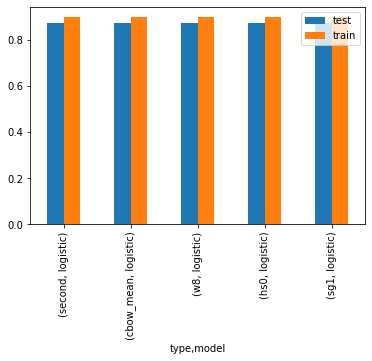

In [31]:
results.nlargest(5, 'test').plot.bar()

Using either skip_grams or c_bow mean, I can acheive a higher accuracy on the logistic test scores. This also provides the best precision and recall scores across the board on the dataset. Additionally, I find that these scores mimic the logistic results seen in the google pre-trained model; which also had its best results return as logistic.